## Imports and Setup

In [31]:
import os
import sys
sys.path.insert(0, "../utils/")
import geoutils
import cnn_utils
import config

import pandas as pd
import numpy as np
import geopandas as gpd

import torch
import torchsummary

pd.set_option('mode.chained_assignment', None)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Dataset

INFO:root:{'NO_ROOF': 0, 'GABLE': 1, 'HIP': 2, 'FLAT': 3}


Config: {'attribute': 'roof_type', 'data': 'LIDAR_DOM', 'mode': 'LIDAR', 'batch_size': 32, 'n_workers': 4, 'n_epochs': 60, 'model': 'inceptionv3', 'pretrained': True, 'resampler': 'RandomOverSampler', 'scheduler': 'ReduceLROnPlateau', 'optimizer': 'Adam', 'label_smoothing': 0.1, 'lr': 1e-05, 'img_size': 299, 'momentum': None, 'gamma': None, 'step_size': None, 'patience': 7, 'dropout': None, 'config_name': 'cnn-roof_type-inceptionv3-LIDAR_DOM', 'rasters_dir': '../data/rasters/', 'vectors_dir': '../data/vectors/', 'tile_dir': '../data/tiles/', 'csv_dir': '../data/csv/', 'out_dir': '../outputs/', 'exp_dir': '../exp/', 'log_dir': '../logs/'}


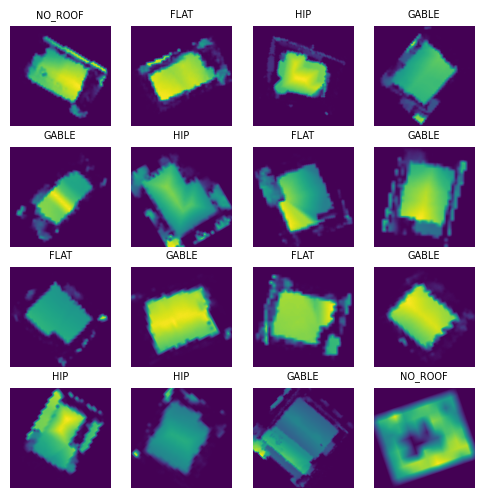

In [73]:
prefix = '.'
phases = ["TRAIN", "TEST"]
config_file = "../configs/cnn/cnn-roof_type-inceptionv3-LIDAR_DOM.yaml"
c = config.load_config(config_file, prefix=prefix)
print(f"Config: {c}")
data, data_loader, classes = cnn_utils.load_dataset(c, phases, prefix)
cnn_utils.visualize_data(data, data_loader, phase='TRAIN', mode=c['data'].split('_')[0])

INFO:root:{'NO_ROOF': 0, 'GABLE': 1, 'HIP': 2, 'FLAT': 3}


Config: {'attribute': 'roof_type', 'data': 'RGB_DOM', 'batch_size': 32, 'n_workers': 4, 'n_epochs': 60, 'model': 'efficientnetb0', 'pretrained': True, 'resampler': 'RandomOverSampler', 'scheduler': 'ReduceLROnPlateau', 'optimizer': 'Adam', 'label_smoothing': 0.1, 'lr': 1e-05, 'img_size': 224, 'momentum': None, 'gamma': None, 'step_size': None, 'patience': 7, 'dropout': None, 'config_name': 'cnn-roof_type-efficientnetb0-RGB_DOM', 'rasters_dir': '../data/rasters/', 'vectors_dir': '../data/vectors/', 'tile_dir': '../data/tiles/', 'csv_dir': '../data/csv/', 'out_dir': '../outputs/', 'exp_dir': '../exp/', 'log_dir': '../logs/'}


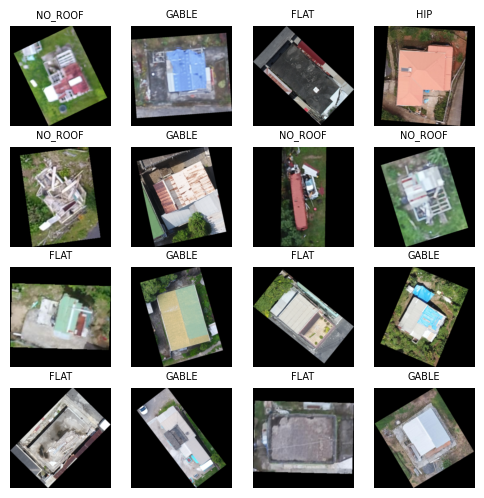

In [3]:
config_file = "../configs/cnn/cnn-roof_type-efficientnetb0-RGB_DOM.yaml"
c = config.load_config(config_file, prefix=prefix)
print(f"Config: {c}")
data, data_loader, classes = cnn_utils.load_dataset(c, phases, prefix)
cnn_utils.visualize_data(data, data_loader, phase='TEST', mode=c['data'].split('_')[0])

## Load Model

In [12]:
from torch_lr_finder import LRFinder
import torch.nn as nn
mode = c['data'].split("_")[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model, criterion, optimizer, scheduler = cnn_utils.load_model(
    n_classes=len(classes),
    model_type=c["model"],
    pretrained=c["pretrained"],
    scheduler_type=c["scheduler"],
    optimizer_type=c["optimizer"],
    lr=c["lr"],
    momentum=c["momentum"],
    gamma=c["gamma"],
    step_size=c["step_size"],
    patience=c["patience"],
    dropout=c["dropout"],
    device=device,
    mode=mode
)
#print(model)
torchsummary.summary(model, (1, c['img_size'], c['img_size']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,